## <h1><center>Workshop Final: Predicción del Precio de un Activo Financiero/Criptomoneda</center></h1>

## Ejemplo de Aplicación: McDonalds

<a id="indice"></a> 
## Índice

### <a href='#section_objetivos'>0. Objetivos del Workshop Final</a>


### <a href='#section_introduccion'>1. Actualización y carga de bibliotecas</a>
- #### <a href='#1.1'>1.1 Carga de datos y armado del DataFrame</a>
- #### <a href='#1.2'>1.2 Análisis exploratorio de los datos</a>


### <a href='#2.'>2. Entrenamiento de los modelos de series de tiempo</a>

### <a href='#3.'>3. Cálculo de errores para la evaluación de los modelos</a>
- #### <a href='#3.1'>3.1 Gráfico de predicciones vs reales en Entrenamiento</a>
- #### <a href='#3.2'>3.2 Gráfico de predicciones vs reales en Test</a>

### <a href='#4.'>4 Líneas futuras y próximos paso</a>

<a id="section_objetivos"></a> 
## 0. Objetivos del Workshop
<a href='#indice'>Volver a TOC</a>

El objetivo de este trabajo final consiste en generar un modelo que permita predecir el precio d eun activo financiero/criptomoneda de manera general. Es decir, que cualquiera sea el activo o criptomodela elegida, se pueda obtener un análisis estadístico descriptivo de la misma y un modelo de predicción que mejor se ajuste.
Para ello, se conecta a la API de yahoo finance para obtener información del activo, su fecha de inicio y así poder realizar los análisis y predicción correspondiente.
En esta notebook, a modo de ejemplo, se presenta el caso de McDonalds.

<a id="section_introduccion"></a> 
## 1. Actualización y carga de bibliotecas
<a href='#indice'>Volver a TOC</a>

En primera instancia, se cargarán todas las bibliotecas a utilizar. Algunas de ellas no se encuentran en el ambiente o requieren ser actualizadas, es por ello que dejamos las siguientes líneas comentadas para que se instalen las mismas

In [1]:
#!pip install --upgrade pandas --user

In [2]:
#!pip install --upgrade pandas-datareader --user

In [3]:
#!pip install --upgrade mplfinance --user

En caso que tire error cuando quiera conectarse a la API de yahoo finance (en la función _captura_datos_), recomendamos reiniciar jupyter lab una vez instaladas y actualizadas las librerías, o bien instalarlas directamente desde anaconda prompt, mediante las siguientes sintaxis:
- pip install --upgrade pandas
- pip install --upgrade pandas-datareader
- pip install --upgrade mplfinance

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

#import warnings
#warnings.filterwarnings('ignore')

import pandas_datareader.data as web
import datetime
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA

import mplfinance as mpf

import statsmodels.api as sm

import plotly.subplots as ms
import plotly.graph_objects as go
import TimeSeriesAnalysis as ts

<a id="1.1"></a> 
## 1.1 Carga de datos y armado del DataFrame
<a href='#indice'>Volver a TOC</a>

Debido a que este trabajo apunta a poder analizar cualquier activo que el usuario quiera elegir y esté disponible en la API, se creó un archivo .py donde allí se alojan funciones creadas para falicitar esto último. La función _captura_datos_ permite elegir el tipo de activo,la fecha de inicio (año, mes día) y el intervalo (día, mes) para poder ser analizado.

In [2]:
data = ts.captura_datos("mcd","2015, 1, 1")

In [3]:
data.head()

High        Low       Open      Close       Volume  \
Date                                                                   
2015-01-01   95.000000  88.769997  94.129997  92.440002  152776400.0   
2015-02-01   99.879997  91.430000  92.050003  98.900002  141328000.0   
2015-03-01  101.089996  94.940002  98.900002  97.440002  164772700.0   
2015-04-01   99.349998  94.459999  96.809998  96.550003  136319600.0   
2015-05-01  101.080002  95.570000  96.730003  95.930000  131649800.0   

            Adj Close  MA20        MA5  timeIndex  
Date                                               
2015-01-01  77.189453   NaN        NaN          0  
2015-02-01  82.583710   NaN        NaN          1  
2015-03-01  82.071640   NaN        NaN          2  
2015-04-01  81.322029   NaN        NaN          3  
2015-05-01  80.799812   NaN  96.252002          4

In [4]:
data.describe()

High         Low        Open       Close        Volume  \
count   83.000000   83.000000   83.000000   83.000000  8.300000e+01   
mean   171.657710  158.698073  164.455302  166.236386  8.749706e+07   
std     46.501540   43.671046   45.135857   44.917149  3.439102e+07   
min     95.000000   87.500000   92.050003   92.440002  2.564768e+06   
25%    125.895000  117.570000  121.880001  122.314999  6.402880e+07   
50%    173.169998  155.800003  165.720001  167.289993  7.756290e+07   
75%    214.794998  193.455002  198.180000  202.205002  1.086716e+08   
max    249.949997  241.990005  245.240005  244.550003  1.797087e+08   

        Adj Close        MA20         MA5  timeIndex  
count   83.000000   64.000000   79.000000  83.000000  
mean   155.288450  166.206313  166.095899  41.000000  
std     49.120059   33.501141   42.301240  24.103942  
min     77.189453  109.157000   96.252002   0.000000  
25%    107.652367  136.991124  122.397999  20.500000  
50%    155.707794  169.920499  165.870001  41.000000  
75%    193.194160  195.044376  202.159001  61.500000  
max    244.550003  218.891002  241.616003  82.000000

<a id="1.2"></a> 
## 1.2 Análisis exploratorio de los datos
<a href='#indice'>Volver a TOC</a>

Luego, se creó la función _graficar_datos_ con el fin de poder visualizar las carácterística de la serie de tiempo (tendencia,estacionalidad,ciclos y aleatoriedad) con el fin de junto otras visualizaciones (histogramas, boxplots) poder tener un pequeño análisis estadístico descriptivo de tipo de activo elegido

<Figure size 432x288 with 0 Axes>

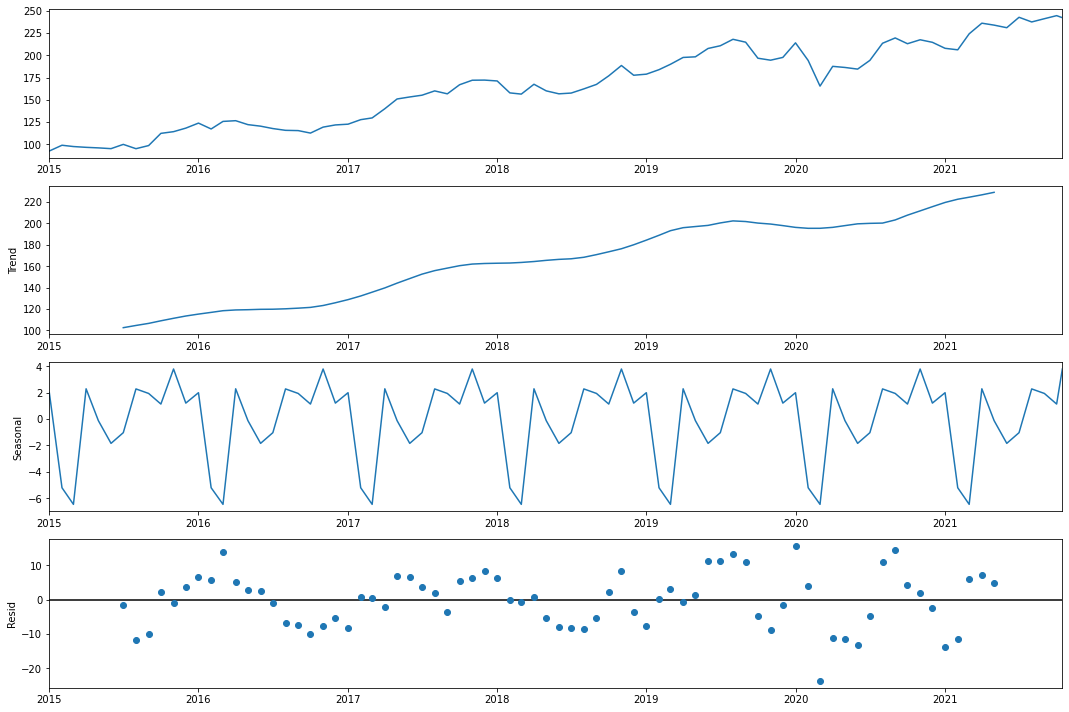

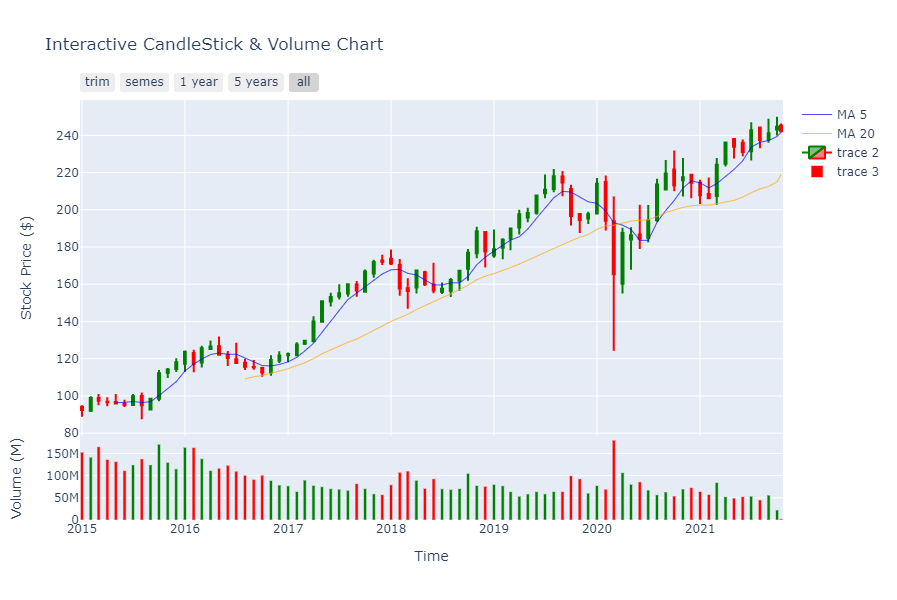

In [5]:
ts.graficar_datos(data);

En el primer gráfico (el cual se divide en 4) se puede ver las características de una serie de tiempo (tendencia, estacionalidad, ciclos y aleatoriedad).
- El primero de estos, grafica los datos extraídos de la API, es decir, el precio de cierre por mes del activo financiero.
- El segundo gráfico, muestra la tendencia de la serie de tiempo. Aquí puede verse una tendencia en alza del precio de McDonalds.
- El tercer gráfico, muestra la estacionalidad de la serie. Se puede ver que la misma se mantiene constante.
- Por último, el cuarto gráfico muestra los residuos. La dispersión aumenta en los últimos periodos.

El segundo gráfico, es de tipo interactivo, en donde puede observarse la serie de tiempo, junto con 2 gráficos de mévia móvil (5 muestras y 20 muestras). Además, se agrega el gráfico del volumen del activo.


<a id="2."></a> 
## 2. Entrenamiento de los modelos de series de tiempo
<a href='#indice'>Volver a TOC</a>

Puede suceder que la última observación y la anteúltima, posean el mismo mes arreglado. Para evitar esto, se procede a eliminar el último registro si es que ocurre esto

Ahora pasamos a seleccionar el modelo con el cual queremos predecir el activo elegido. Para eso, usamos la funcíón _evaluación_ cuyos parámetros son:
- df: DataFrame elegido
- pred_size: Tamaño del dataframe de test
- lags: cantidad de muestras para la ventana temporal del ACF y PACF
- model: Modelo a elegir, los cuales son:
    - linear
    - quad
    - log
- estacionalidad: Es un booleano (True o False) para elegir si se quiere modelar con estacionalidad o no.
- volumen: Es un booleano (True o False) para elegir si se quiere modelar junto con el volumen como variable predictora.

La función arroja como resultado si los modelos utilizados para predecir el precio de la serie de tiempo poseen o no estacionalidad. Si la tienen, arroja el resultado del p valor asociado al Test de Dickey-Fuller (el cual permite testear si una serie es o no estacionaria).

En caso que el modelo no arroje una serie estacionaria, la función lo aclara y recomienda que se haga más diferenciación.

Esto ocurre porque se asume que los modelos sin la predicción de ARIMA (es decir, un modelo que intenta predecir la aleatoriedad de la serie) son peores que cuando se le agrega el residuo. Es por ello que es necesario chequear la estacionariedad o no de los modelos para cuando se aplica ARIMA.

El modelo elegido linear_est posee un p= 0.002470184340968341
El modelo elegido quad_est no es estacionario, hacer mas diferenciación
El modelo elegido log_est posee un p= 0.04902287377005531
El modelo elegido linear posee un p= 0.004801571008416144
El modelo elegido quad posee un p= 0.0027887164684545357
El modelo elegido log no es estacionario, hacer mas diferenciación


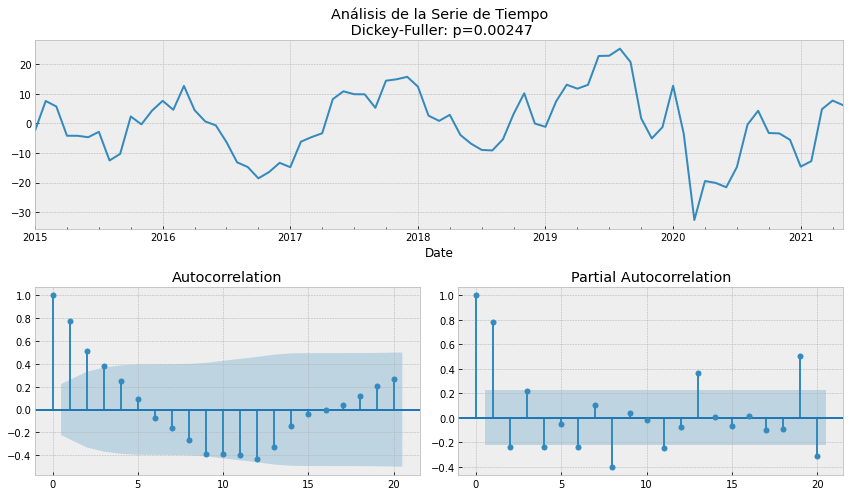

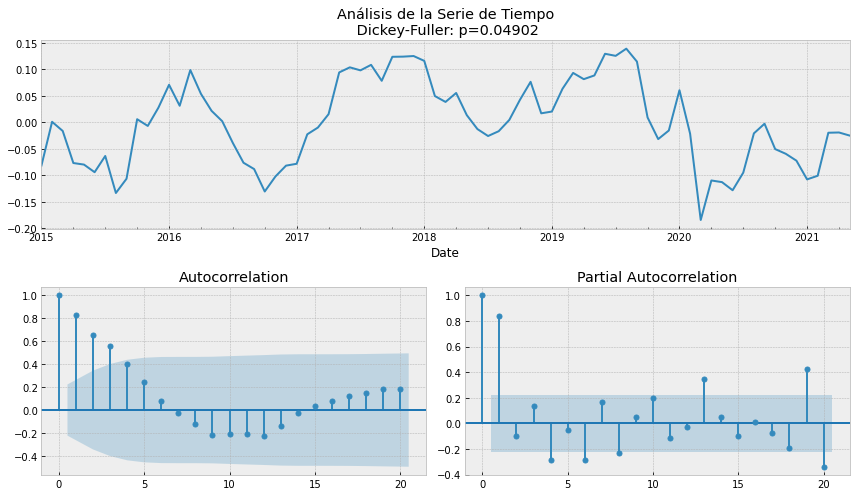

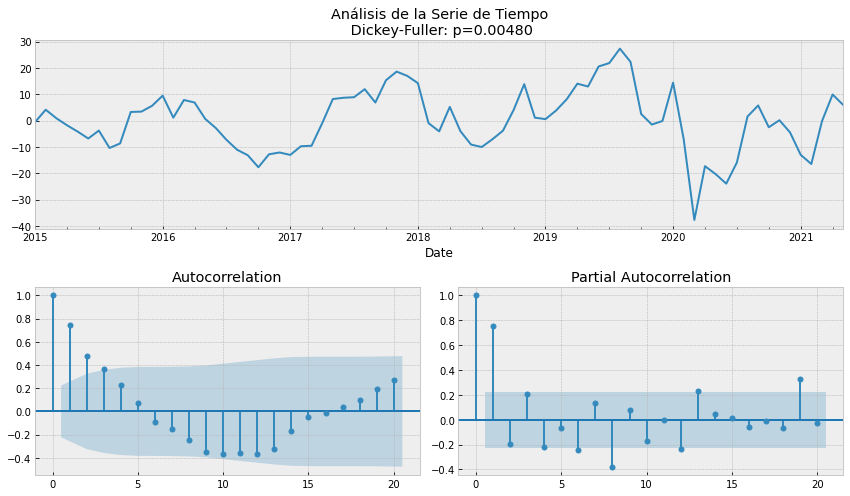

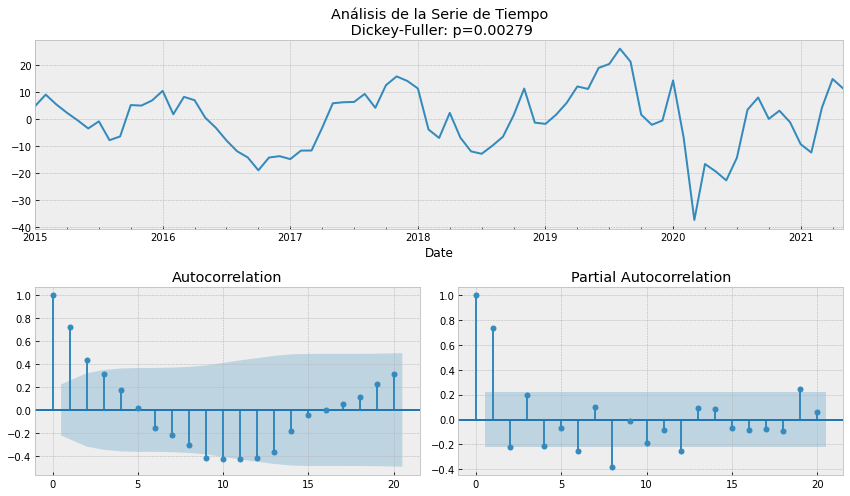

In [6]:
models = ['linear','quad','log']
est = [True, False]
model = {}
for j in est:
    for i in models:
        modelo = ts.evaluacion(df=data,pred_size=6,lags=20,model=i,estacionalidad=j,volumen=False)
        if j:
            model[str(i)+'_est']=modelo
        else:
            model[str(i)]=modelo

Si bien con estos gráficos, uno puede obtener cuál es el valor deseado de p y q. Se procede a realizar un gridsearch donde se toman 5 valores para cada caso, con el fin de evaluar varios modelos y obtener el que mejor resultados presente.

In [7]:
p_list = []
q_list = []
d_list = []
for j in est:
    if j:
        for i in models:
            try:
                RMSE, p, q, d, model_label = ts.eval_models_hyperparameters(model[str(i)+'_est'],numbers=5,model_label=str(i)+'_est',alpha=0.05)
                df = pd.DataFrame([RMSE, p, q, d]).T.rename(columns={0:'RMSE',1:'p',2:'q',3:'d'})
                df['model'] = model_label
                df_index = df.RMSE.idxmin() 
                fila_min = df.iloc[df_index]
                p = int(fila_min.p)
                q = int(fila_min.q)
                d = int(fila_min.d)
                p_val,q_val,d_val = ts.arima(model[str(i)+'_est'], p=p, d=d, q=q, alpha=0.05)
                p_list.append(p_val)
                q_list.append(q_val)
                d_list.append(d_val)
            except:
                continue
        else:
            for i in models:
                try:
                    RMSE, p, q, d, model_label = ts.eval_models_hyperparameters(model[str(i)],numbers=5,model_label=str(i),alpha=0.05)
                    df = pd.DataFrame([RMSE, p, q, d]).T.rename(columns={0:'RMSE',1:'p',2:'q',3:'d'})
                    df['model'] = model_label
                    df_index = df.RMSE.idxmin() 
                    fila_min = df.iloc[df_index]
                    p = int(fila_min.p)
                    q = int(fila_min.q)
                    d = int(fila_min.d)
                    p_val, q_val,d_val = ts.arima(model[str(i)],p=p,d=d,q=q,alpha=0.05)
                    p_list.append(p_val)
                    q_list.append(q_val)
                    d_list.append(d_val)
                except:
                    continue

#ts.arima(modelo,2,0,2,0.05)
#model.keys()

In [8]:
print(df)
df_index = df.RMSE.idxmin() 
df_index

         RMSE    p    q    d model
0   12.254537  0.0  0.0  0.0   log
1   11.343886  0.0  1.0  0.0   log
2   11.279483  0.0  2.0  0.0   log
3   10.495786  0.0  3.0  0.0   log
4   10.944662  0.0  4.0  0.0   log
..        ...  ...  ...  ...   ...
64   3.623607  2.0  4.0  2.0   log
65  22.630008  3.0  0.0  2.0   log
66   3.674454  3.0  1.0  2.0   log
67  17.395472  4.0  0.0  2.0   log
68  22.333023  4.0  1.0  2.0   log

[69 rows x 5 columns]


57

<a id="3."></a> 
## 3. Cálculo de errores para la evaluación de los modelos
<a href='#indice'>Volver a TOC</a>

In [9]:
dic = {}
dicc = {}
for j in est:
    if j:
        for i in models:
            try:
                df_train = model[str(i)+'_est'][1]
                df_test = model[str(i)+'_est'][2]
                dic['RMSE_train'] = ts.RMSE(df_train.model_ARIMA,df_train.Close)
                dic['RMSE_test'] = ts.RMSE(df_test.model_ARIMA,df_test.Close)
                dic['model'] = str(i) + '_est'
                lista = list(dic.values())
                dicc[str(i)+'_est'] = lista
            except:
                continue
        else:
            for i in models:
                try:
                    df_train = model[str(i)][1]
                    df_test = model[str(i)][2]
                    dic['RMSE_train'] = ts.RMSE(df_train.model_ARIMA,df_train.Close)
                    dic['RMSE_test'] = ts.RMSE(df_test.model_ARIMA,df_test.Close)
                    dic['model'] = str(i)
                    lista = list(dic.values())
                    dicc[str(i)] = lista
                except:
                    continue

df_eval = pd.DataFrame(dicc).T.rename(columns={0:'RMSE_train',1:'RMSE_test',2:'model'}).reset_index(drop=True)
df_eval['p'] = p_list
df_eval['q'] = q_list
df_eval['d'] = d_list

In [10]:
df_eval.RMSE_train = df_eval.RMSE_train.astype(float)
df_eval.RMSE_test = df_eval.RMSE_test.astype(float)
df_eval.RMSE_train = df_eval.RMSE_train.round(2)
df_eval.RMSE_test = df_eval.RMSE_test.round(2)
df_eval.sort_values(by='RMSE_test')

RMSE_train  RMSE_test       model  p  q  d
3        6.71       2.48      linear  4  2  0
0       12.61       2.61  linear_est  4  4  1
4       15.24       2.87        quad  1  2  2
5       16.92       2.94         log  1  2  2
2       14.32       3.01     log_est  1  0  2
1       11.25       3.16    quad_est  3  0  1

Este DataFrame muestra los errores RMSE calculados para cada modelo, con sus valores p y q óptimos (es decir, los errores más chicos para cada modelo). Se puede ver que el mejor modelo de todos es el de tendencia lineal.


In [11]:
df_train_graf, df_test_graf = ts.dataframe_to_graph(model)

In [12]:
df_train_graf.head()

Close  linear_est   quad_est     log_est      linear  \
Date                                                                   
2015-01-01  92.440002         NaN        NaN         NaN   93.913375   
2015-02-01  98.900002   91.318751  87.014343         NaN   94.599828   
2015-03-01  97.440002   92.732156  88.700711   98.967741  100.517755   
2015-04-01  96.550003   96.380519  93.960678  107.867114   98.253003   
2015-05-01  95.930000   99.945386  97.311976  105.377120   99.878652   

                 quad         log  
Date                               
2015-01-01        NaN         NaN  
2015-02-01        NaN         NaN  
2015-03-01  92.003393  101.880627  
2015-04-01  96.798784  105.685224  
2015-05-01  99.564919  107.482989

In [13]:
df_test_graf

Close  linear_est    quad_est     log_est      linear  \
Date                                                                     
2021-06-01  230.990005  235.107872  233.292809  234.040309  234.172969   
2021-07-01  242.710007  241.505346  236.880769  236.946207  238.558712   
2021-08-01  237.460007  239.352194  241.087328  240.159518  238.890990   
2021-09-01  241.110001  237.364311  241.765774  240.561145  241.173547   
2021-10-01  244.550003  244.029070  242.642583  242.839015  242.144508   
2021-10-15  242.250000  244.358900  244.125678  243.402788  243.556509   

                  quad         log  
Date                                
2021-06-01  233.739855  233.860677  
2021-07-01  237.191630  237.474824  
2021-08-01  238.276726  238.714252  
2021-09-01  240.929310  241.547071  
2021-10-01  242.556199  243.357977  
2021-10-15  244.866675  245.871759

<a id="3.1"></a> 
## 3.1 Gráfico de predicciones vs reales en Entrenamiento
<a href='#indice'>Volver a TOC</a>

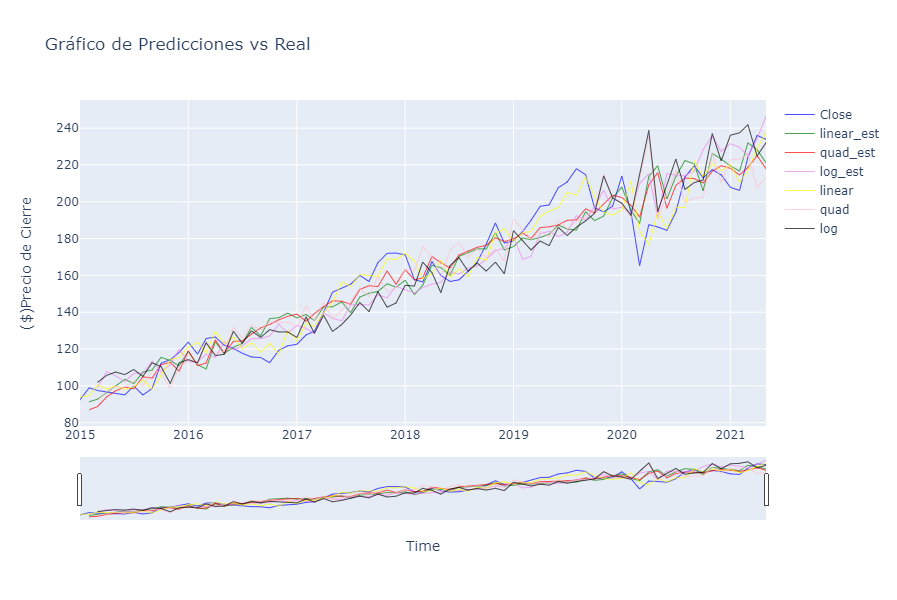

In [14]:
ts.graficar_predicciones_arima(df_train_graf)

<a id="3.2"></a> 
## 3.2 Gráfico de predicciones vs reales en Test
<a href='#indice'>Volver a TOC</a>

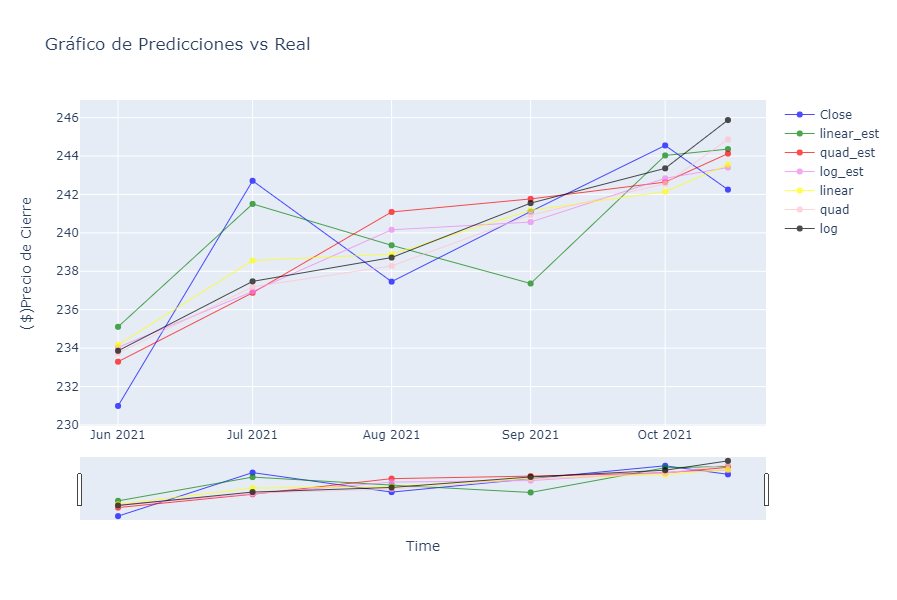

In [15]:
ts.graficar_predicciones_arima(df_test_graf)

<a id="4."></a> 
## 4 Líneas futuras y próximos pasos
<a href='#indice'>Volver a TOC</a>

La idea de este trabajo final consiste en poder realizar una interfaz que permita obtener la predicción de cualquier activo financiero. Si bien se logró el trabajo, el mismo tiene muchas líneas de mejora tales como:
- Agregado de estimación por días y modelo de estacionalidad para esto
- Análisis del volumen y predicción del mismo
- Realizar un deploy del modelo y poder visualizarlo en una pagina web
- Recomendación sobre puntos de entrada de salida del activo

Estas cuestiones excedieron el alcance del proyecto, pero quedarán pendientes a realizar para seguir mejorando la performance del mismo.

